**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**May, 2022**

Here I re-annotate the trophoblasts by including cell sub-types. I also calculate the marker genes of each cell identity and the DE genes of Explant vs Freash tissue.


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import sys
import anndata

import matplotlib.pyplot as plt
import matplotlib as mpl


#For TF-IDF
import episcanpy as epi
from sklearn.feature_extraction.text import TfidfTransformer

In [3]:
def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = '../results/images/integrated/fetalSurgicalSubset/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
bamnostic           NA
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
episcanpy           0.3.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jup

'/opt/conda/bin/python'

In [4]:
def identityTransfer(adata_CellsNewID, adata, field='identity'):
    
    '''
    Function to transfer the value in a .obs column, modifying only the cells included in adata_CellsNewID
    
    Parameters:
        adata_CellsNewID: anndata object with cells. These should have in their .obs[field] the new values to be transfer to adata
        adata: anndata object to modify. The value in .obs[field] will be modifies for all the cells in adata_CellsNewID
        field: column name in .obs to operate in.
        
     Return:
        anndata object with the metadata modified
        
    '''
    
    #converting categorical into strings to introduce new categories
    adata.obs[field]=adata.obs[field].astype("string")


    #assigning the new categories to the cells in adata
    for cell in adata_CellsNewID.obs.index:
        adata.obs[field][cell] = adata_CellsNewID.obs[field][cell]

    #Returning strings into categorical 
    adata.obs[field]=adata.obs[field].astype("category")
    
    return(adata)

In [105]:
def runTF_IDF(adata, groupby, method='wilcoxon'):
    
    '''
    Function to run TF-IDF and DE analysis. TF-IDF means term-frequency times inverse document-frequency. 
    Its goal is to scale down the impact of tokens that occur very frequently (i.e. less informative)
    than features that occur in a small fraction of the training corpus.
    The the function applies a DE analysis.
    
    Parameters:
        adata: anndata object with cells.
        groupby: column name in .obs to make the DE comparison.
        method: method to use for Differential expression.
    
    Return:
        anndata object with the DE genes stored in adata.uns['rank_genes_groups']
        
    '''
    
    
    counts = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, asview=False)


    #-- Binarize counts matrix (1 if expressed, 0 otherwise)
    adata_bin = epi.pp.binarize(counts, copy=True)
    adata_bin.X.shape


    #-- Compute TF-IDF
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(adata_bin.X.T)
    adata_bin.X = tfidf.T
    adata_bin.X.shape


    #-- Compute Mann-Withney test with scanpy
    sc.tl.rank_genes_groups(adata_bin, groupby= groupby, use_raw=False, method=method)

    return(adata_bin)

In [137]:
def Barplot(which_var, adata, var='identity', height=3, color = False, suffix= ''):
    
    '''
    Function to plot barplots plotting the proportion of cells per catergory in var, coming from each category in which_var.
    
    Parameters:
        which_var: column name in .obs. Contains the categories to contrast.
        adata: anndata object.
        var: column name in .obs. It contains the categories of the cells.
        height: plot height
        color: colors to use
        suffix: string. Suffix to be added at the end of the name of the plot.
    
    Return:
        Saves bar plot as a pdf.
        
    '''
    
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+ suffix+'.pdf', bbox_inches='tight',
                       dpi=300, orientation='landscape', format= 'pdf', optimize=True)

In [85]:
#Saving the modified object
adata=sc.read('../results/scVI/S8_scVIintegrated_fetalSurgSubset_adata_latent20.h5ad')

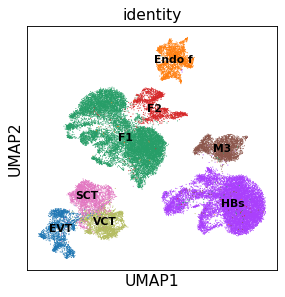

In [6]:
# use scVI imputed values for plotting
sc.pl.umap(adata, color=['identity' ], legend_loc='on data',legend_fontsize='x-small')

### Re-annotating the Trophoblast sub-populations

I will explore the annotation reported Anna Arutyunyan:

 

In [7]:
Trophoblasts=sc.read('../results/scVI/S9_scVIintegrated_Trophoblasts_latent30.h5ad')

In [8]:
Trophoblasts.obs['leiden_scvi2']= Trophoblasts.obs['leiden_scvi']

In [9]:
#LATENT 30
sc.pp.neighbors(Trophoblasts, n_neighbors=15, use_rep="X_scVI_n_latent_20")
sc.tl.umap(Trophoblasts)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


running Leiden clustering
    finished: found 15 clusters and added
    'leiden_scvi', the cluster labels (adata.obs, categorical) (0:00:00)


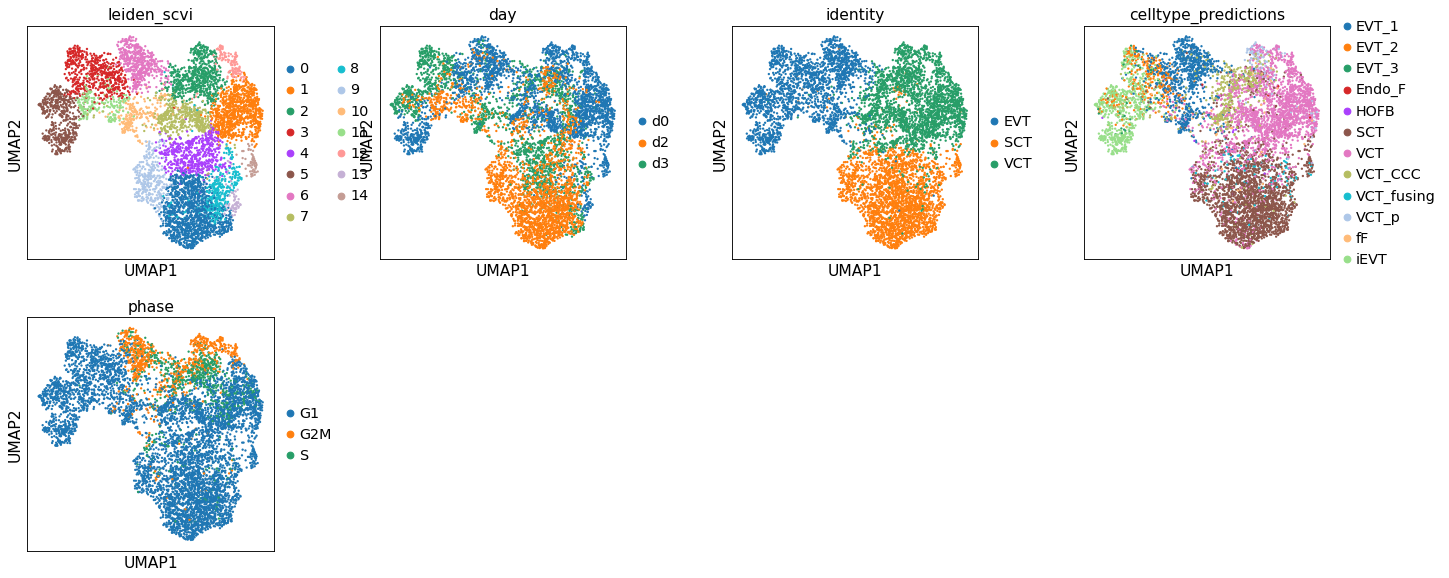

In [21]:
#clustering
sc.tl.leiden(Trophoblasts, key_added="leiden_scvi", resolution=0.8)


sc.pl.umap(Trophoblasts, color=["leiden_scvi",'day', 'identity','celltype_predictions','phase'],
           wspace=0.3,)

In [12]:
#Loading the predictions done using all the cells as training set, and only the
# Trophoblast as test set

prediction= pd.read_csv('../results/log_regression/logreg_from_P13_trophoblast_to_explant_premrna_HVGs_predictions_20220124.csv', index_col=0)

In [13]:
#Changing names to differentiate from the ol predictions
prediction['celltype_predictions2']= prediction['celltype_predictions']
prediction['probabilities2']= prediction['probabilities']

prediction= prediction.drop(columns=['celltype_predictions', 'probabilities'])

In [14]:
#Adding the predictions to the metadata
Trophoblasts.obs= Trophoblasts.obs.join(prediction)

In [15]:
##----- Trying with prediction using the newest MFI data set
##----- but only the Trophoblasts as training set

In [16]:
#Loading the prediction
prediction= pd.read_csv('../results/log_regression/logreg_trophoblastOnly_to_explant_premrna_HVGs_predictions_20220502.csv', index_col=0)

In [17]:
prediction.head()

celltype_predictions  probabilities
Pla_HDBR10917730_AAACCCAGTAGCTCGC                  SCT       0.999965
Pla_HDBR10917730_AAAGGTATCAAGGTGG                  VCT       0.647959
Pla_HDBR10917730_AACAACCCACAATGTC                  SCT       0.995515
Pla_HDBR10917730_AACACACAGCTCATAC           VCT_fusing       0.879061
Pla_HDBR10917730_AATGCCATCCGCTGTT           VCT_fusing       0.999934

In [18]:
#Changing names to differentiate from the ol predictions
prediction['celltype_predictions3']= prediction['celltype_predictions']
prediction['probabilities3']= prediction['probabilities']

prediction= prediction.drop(columns=['celltype_predictions', 'probabilities'])


#Adding the predictions to the metadata
Trophoblasts.obs= Trophoblasts.obs.join(prediction)

#Checking the predictions loaded so far
Trophoblasts.obs[['celltype_predictions', 'celltype_predictions2', 'celltype_predictions3']] 

celltype_predictions celltype_predictions2  \
Pla_HDBR10917730_AAACCCAGTAGCTCGC                  SCT                   SCT   
Pla_HDBR10917730_AAAGGTATCAAGGTGG                  VCT                   VCT   
Pla_HDBR10917730_AACAACCCACAATGTC                  VCT               VCT_CCC   
Pla_HDBR10917730_AACACACAGCTCATAC           VCT_fusing               VCT_CCC   
Pla_HDBR10917730_AATGCCATCCGCTGTT                  SCT            VCT_fusing   
...                                                ...                   ...   
Pla_HDBR11345033_TTGTTGTTCCCATAGA                EVT_2               VCT_CCC   
Pla_HDBR11345033_TTGTTTGAGTCTGCAT                  VCT               VCT_CCC   
Pla_HDBR11345033_TTTACTGGTATACGGG                EVT_2               VCT_CCC   
Pla_HDBR11345033_TTTCATGCATATCTCT                EVT_1               VCT_CCC   
Pla_HDBR11345033_TTTGGTTAGCCTAGGA                EVT_1               VCT_CCC   

                                  celltype_predictions3  
Pla_HDBR10917730_AAACCCAGTAGCTCGC                   SCT  
Pla_HDBR10917730_AAAGGTATCAAGGTGG                   VCT  
Pla_HDBR10917730_AACAACCCACAATGTC                   SCT  
Pla_HDBR10917730_AACACACAGCTCATAC            VCT_fusing  
Pla_HDBR10917730_AATGCCATCCGCTGTT            VCT_fusing  
...                                                 ...  
Pla_HDBR11345033_TTGTTGTTCCCATAGA                   SCT  
Pla_HDBR11345033_TTGTTTGAGTCTGCAT                   SCT  
Pla_HDBR11345033_TTTACTGGTATACGGG                 EVT_2  
Pla_HDBR11345033_TTTCATGCATATCTCT               VCT_CCC  
Pla_HDBR11345033_TTTGGTTAGCCTAGGA                   SCT  

[6787 rows x 3 columns]

... storing 'celltype_predictions2' as categorical
... storing 'celltype_predictions3' as categorical


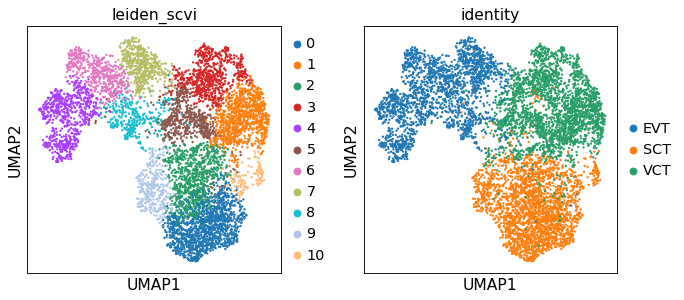

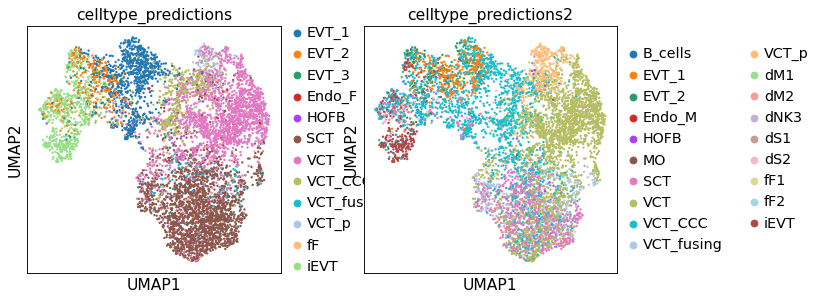

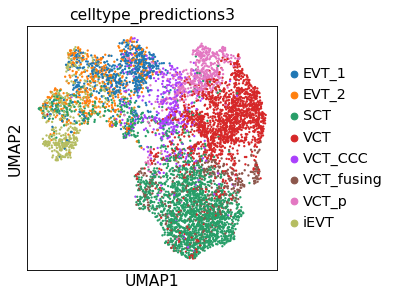

In [19]:
sc.pl.umap(Trophoblasts, color=["leiden_scvi", 'identity'])
sc.pl.umap(Trophoblasts, color=['celltype_predictions','celltype_predictions2'])
sc.pl.umap(Trophoblasts, color=['celltype_predictions3'])



In [24]:
#COpying the value of the leiden cluster. The new column will help to change it's values for
# the cluster identity
Trophoblasts.obs['identity']= Trophoblasts.obs['leiden_scvi']


#Function that changes the cluster names as indicated
Trophoblasts.obs['identity'] = (Trophoblasts.obs["leiden_scvi"].map(lambda x: 
                            {"0": "SCT", "1": "VCT", "2": "VCT_p", "3": "EVT_2", "4": "SCT","5": "iEVT",
                            "6": "EVT_1", "7": "VCT_CCC", "8": "SCT", "9": "SCT", "10": "EVT_1",
                            "11": "EVT_2", "12": "VCT", "13": "SCT", "14": "VCT_fusing"}
                            .get(x, x)).astype("category"))

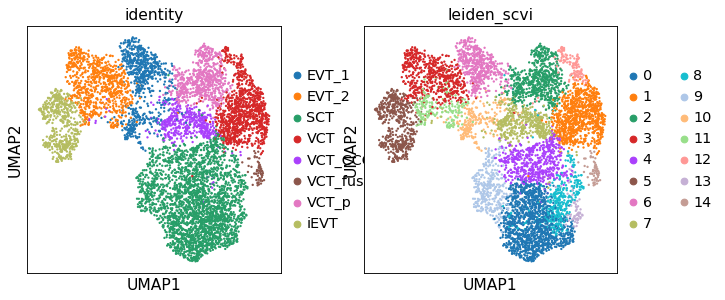

In [25]:
sc.pl.umap(Trophoblasts, color=['identity',"leiden_scvi"])

In [26]:
#Saving the modified object
Trophoblasts.write('../results/scVI/S9_scVIintegrated_Trophoblasts_latent20.h5ad')

In [27]:
#Assigning the old leiden cluster name to the original column. This to avoid confusions in the object
Trophoblasts.obs['leiden_scvi']= Trophoblasts.obs['leiden_scvi2']

#Removing the temp column that keep the old
Trophoblasts.obs= Trophoblasts.obs.drop(columns=['leiden_scvi2'])

In [28]:
#Removing the columns from the newer predictions to keep the old one
Trophoblasts.obs= Trophoblasts.obs.drop(columns=['celltype_predictions2','celltype_predictions3'])

Trophoblasts.obs= Trophoblasts.obs.drop(columns=['probabilities2','probabilities3'])

In [32]:
#Updating the new Trophoblast annotation into the big data set
adata= identityTransfer(Trophoblasts, adata)

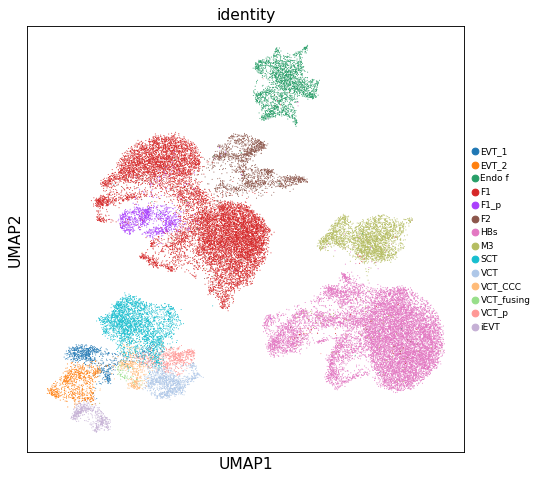

In [86]:
# use scVI imputed values for plotting
sc.pl.umap(adata, color=['identity' ], legend_fontsize='xx-small') #legend_loc='on data',

In [39]:
#Saving the modified object
adata.write('../results/scVI/S8_scVIintegrated_fetalSurgSubset_adata_latent20.h5ad')

### Setting up color palette for future plots

In [87]:
#List with the colors to be use per cell type
colors_final = ['#bb7784', # EVT_1
                '#884451', # EVT_2
                '#ef9708', # Endo f
                '#c6dec7', # F1
                '#8e9f8f', # F1_p
                '#b8e6d5', # F2
                '#76d7ea', # HBs
                '#ff5800', # M3
                '#d6bcc0', # SCT
                '#7d87b9', # VCT
                '#e7a3c8', # VCT_CCC
                '#b53279', # VCT_fusing
                '#e07b91', # VCT_p
                '#510058', # iEVT
               ]

In [94]:
#DF with the row names as the identity of the cells
colors_final_df = pd.DataFrame(index = np.unique(adata.obs['identity']))

In [95]:
#Assign each color per cell type under the column color
colors_final_df.loc['EVT_1', 'color'] = '#bb7784'
colors_final_df.loc['EVT_2', 'color'] = '#884451'
colors_final_df.loc['Endo f', 'color'] = '#ef9708'
colors_final_df.loc['F1', 'color'] = '#c6dec7'
colors_final_df.loc['F1_p', 'color'] = '#8e9f8f'
colors_final_df.loc['F2', 'color'] = '#b8e6d5'
colors_final_df.loc['HBs', 'color'] = '#76d7ea'
colors_final_df.loc['M3', 'color'] = '#ff5800'
colors_final_df.loc['SCT', 'color'] = '#d6bcc0'
colors_final_df.loc['VCT', 'color'] = '#7d87b9'
colors_final_df.loc['VCT_CCC', 'color'] = '#e7a3c8'
colors_final_df.loc['VCT_fusing', 'color'] = '#b53279'
colors_final_df.loc['VCT_p', 'color'] = '#e07b91'
colors_final_df.loc['iEVT', 'color'] = '#510058'

In [96]:
colors_final_df

color
EVT_1       #bb7784
EVT_2       #884451
Endo f      #ef9708
F1          #c6dec7
F1_p        #8e9f8f
F2          #b8e6d5
HBs         #76d7ea
M3          #ff5800
SCT         #d6bcc0
VCT         #7d87b9
VCT_CCC     #e7a3c8
VCT_fusing  #b53279
VCT_p       #e07b91
iEVT        #510058

In [97]:
colors_final_dict= colors_final_df.to_dict()['color']

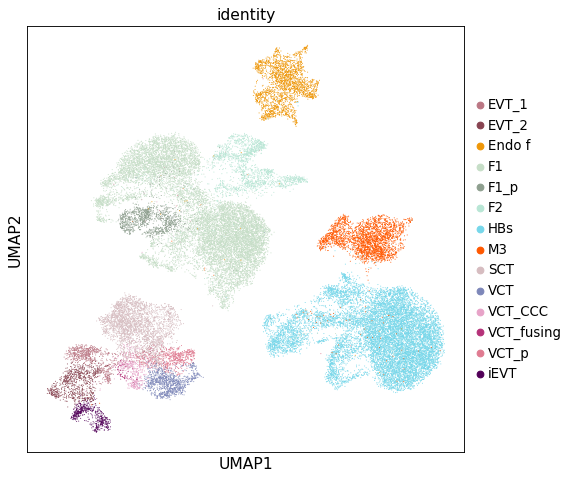

In [98]:
sc.pl.umap(adata,  color=['identity'], palette= colors_final_dict, legend_fontsize=12)

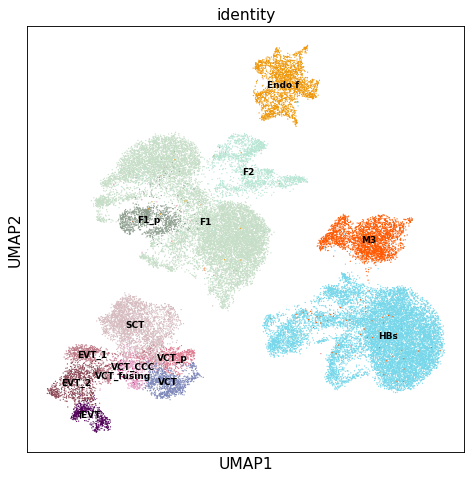

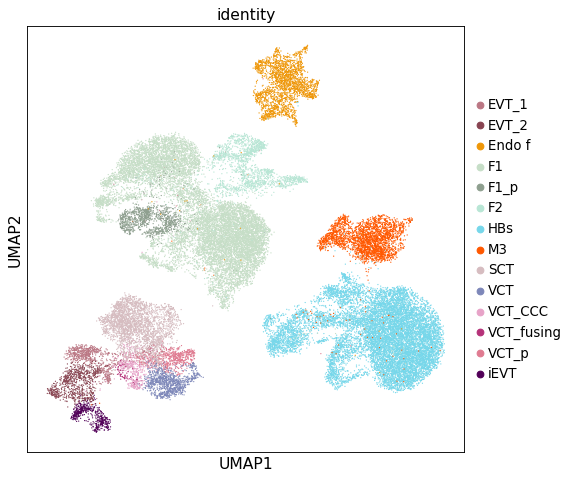

In [99]:
sc.set_figure_params(figsize=(7,7))
sc.pl.umap(adata, color=['identity' ],legend_fontsize='xx-small',legend_loc= 'on data', size=5,
          palette= colors_final_dict, save='_scVI_latent20_fetal_ondata.pdf')

sc.pl.umap(adata, color=['identity' ],legend_fontsize=12, size=5,
          palette= colors_final_dict, save='_scVI_latent20_fetal.pdf')

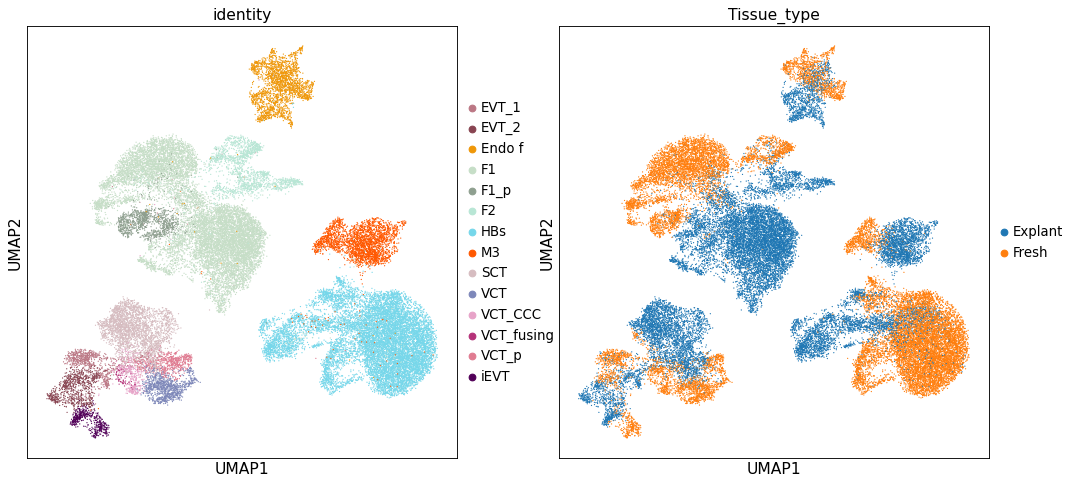

In [100]:
sc.pl.umap(adata, color=['identity','Tissue_type' ],legend_fontsize=12, size=5)

### Definition of broader categories for the cells

Here I will comprise all VCT and EVT under the same category. Might be useful in the future for broader comparisons

In [108]:
#Assigning the old leiden cluster name to the original column. This to avoid confusions in the object
adata.obs['identity_broad']= adata.obs['identity']

In [112]:

#Function that changes the cluster names as indicated
adata.obs['identity_broad'] = (adata.obs["identity"].map(lambda x: 
                            {"EVT_1": "EVT", "EVT_2": "EVT", "Endo f": "Endo f", "F1": "F1", "F1_p": "F1_p","F2": "F2",
                            "HBs": "HBs", "SCT": "SCT", "VCT": "VCT", "VCT_CCC": "VCT", "VCT_fusing": "VCT",
                            "VCT_p": "VCT", "iEVT": "EVT"}
                            .get(x, x)).astype("category"))

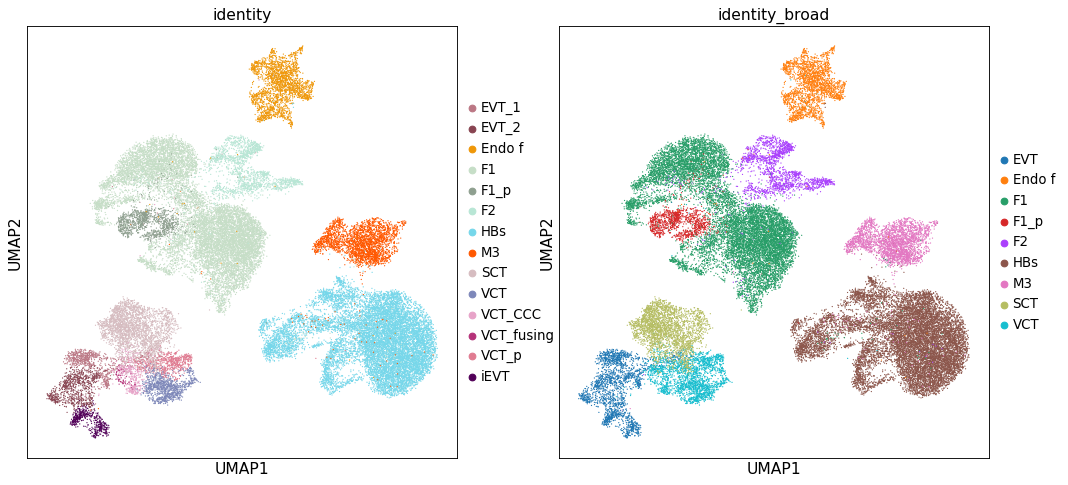

In [114]:
sc.pl.umap(adata, color=['identity','identity_broad' ],legend_fontsize=12, size=5)

In [115]:
#Saving the modified object
adata.write('../results/scVI/S8_scVIintegrated_fetalSurgSubset_adata_latent20.h5ad')

### Differentially expressed genes to differentiate clusters

In [106]:
adata_bin= runTF_IDF(adata, groupby='identity', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:50)


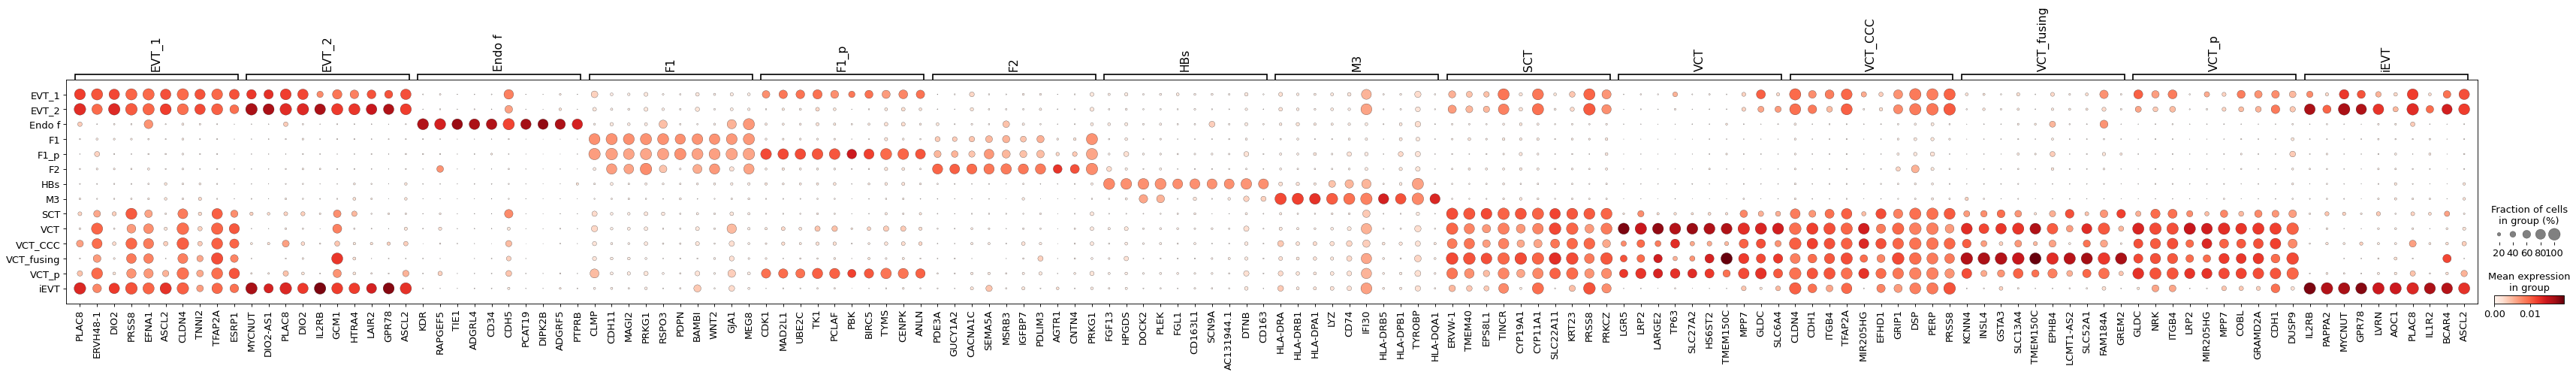

In [122]:
#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=10, dendrogram=False, save='rawTFidf_scanpy.pdf')

In [118]:
adata_counts = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, asview=False)
# Plot with gene expression normalized values
sc.pp.normalize_per_cell(adata_counts, counts_per_cell_after=1e4)
sc.pp.log1p(adata_counts)
sc.pp.scale(adata_counts, max_value=10)

normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


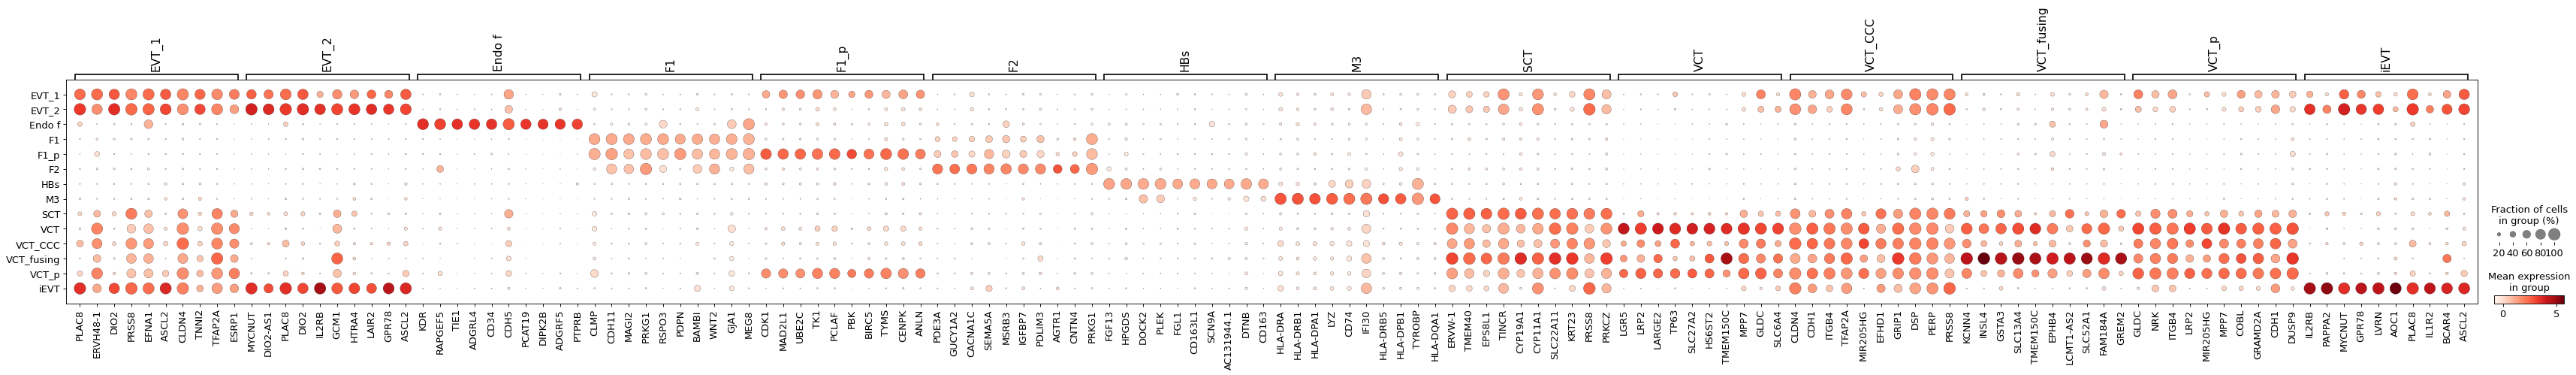

In [121]:
adata_counts.uns['rank_genes_groups'] = adata_bin.uns['rank_genes_groups']
sc.pl.rank_genes_groups_dotplot(adata_counts, n_genes=10, dendrogram=False, save='normTFidf_scanpy.pdf', use_raw = False)

## Comparison of explants vs fresh tissue

As we have different cell types, I will do paired-comparison of explant vs fresh, per cell type

### Cell propotions

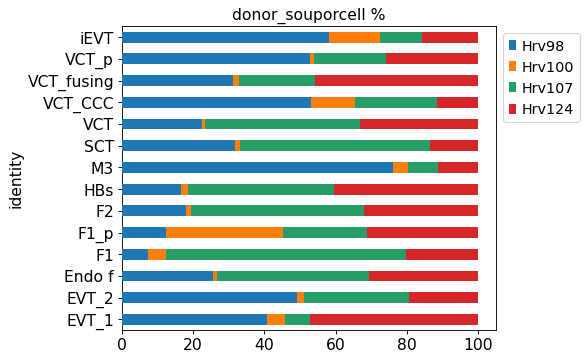

In [126]:
Barplot('donor_souporcell', adata, var='identity', height=5)

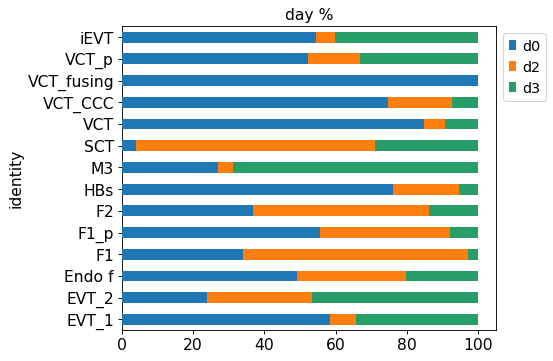

In [127]:
Barplot('day', adata, var='identity', height=5)

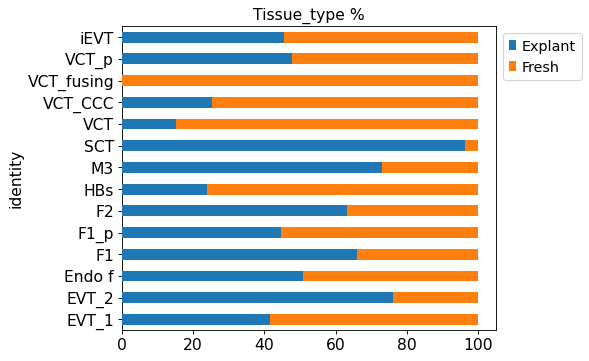

In [133]:
Barplot('Tissue_type', adata, var='identity', height=5)

In [129]:
Explant = adata[adata.obs['Tissue_type'] == 'Explant']
Fresh= adata[adata.obs['Tissue_type'] == 'Fresh']

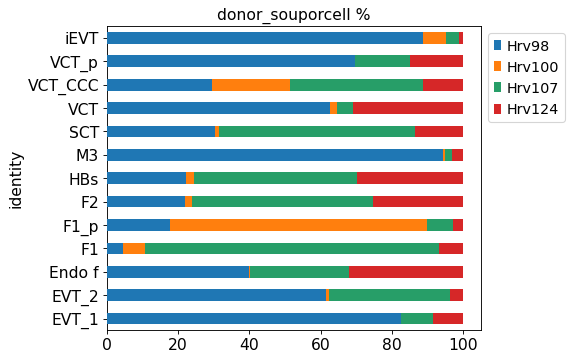

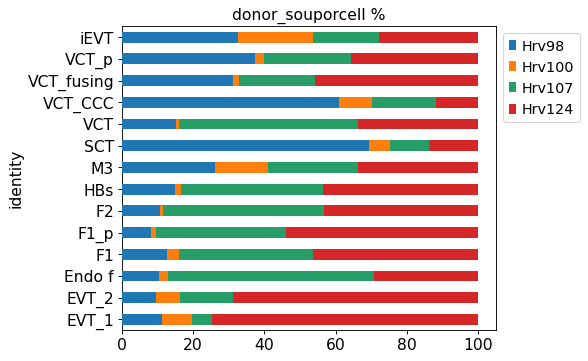

In [134]:
Barplot('donor_souporcell', Explant, var='identity', height=5, suffix='_explant')
Barplot('donor_souporcell', Fresh, var='identity', height=5, suffix='_fresh')

## Differentially expressed genes to differentiate clusters


The goal here is to compare the differences between explant and fresh tissue. As these differences will vary a lot among cell types it is better if I perform a cell type-by-cell type comparison, contrasting fresh vs Explant every time.

In [135]:
#Changing the path to save the images
sc.settings.figdir = '../results/images/integrated/fetalSurgicalSubset/DEexplant_vs_fresh/'


In [136]:
set(adata.obs['identity']) #list of identitites

{'EVT_1',
 'EVT_2',
 'Endo f',
 'F1',
 'F1_p',
 'F2',
 'HBs',
 'M3',
 'SCT',
 'VCT',
 'VCT_CCC',
 'VCT_fusing',
 'VCT_p',
 'iEVT'}

In [10]:
adata_counts = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, asview=False)

#### Endo f

In [138]:
temp_cells = adata[adata.obs['identity_broad'] == 'Endo f']
adata_bin= runTF_IDF(temp_cells, groupby='Tissue_type', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


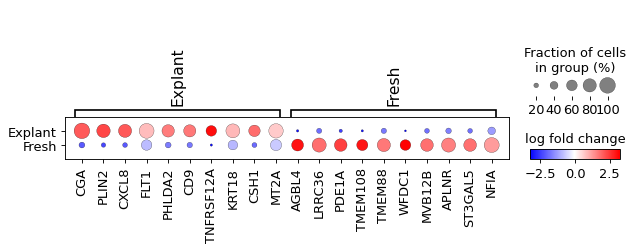

In [139]:
#Plot TF-IDF DE values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=10, dendrogram=False,values_to_plot="logfoldchanges",
                                cmap='bwr', save='tfidf_TissueType_Endof_scanpy.pdf')

In [140]:
# CHunk to save the DF of DE genes. I am only including genes with a log2fc>0.5
dedf = sc.get.rank_genes_groups_df(adata_bin, group='Explant', log2fc_min=0.5, pval_cutoff=0.001)
dedf.to_csv('../results/tables/DEexplant_vs_fresh/deTFIDF_endoF.csv', index=False )


In [142]:
sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2).head(10)
#list(sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2)[ 'names'])

names     scores  logfoldchanges          pvals      pvals_adj
0        CGA  34.589012        2.101175  3.696162e-262  1.168911e-257
1      PLIN2  28.899895        2.361383  1.197597e-183  1.893700e-179
2      CXCL8  26.545803        2.120406  2.871312e-155  3.026841e-151
3  TNFRSF12A  21.738848        3.088361  8.808288e-105  2.321351e-101
4       MMP1  20.097069        2.511750   7.828296e-90   7.736558e-87
5      HBEGF  19.136425        2.057799   1.255977e-81   8.275054e-79
6      FOSL1  18.389330        3.564378   1.599428e-75   8.430316e-73
7      PTGS2  17.894207        6.613627   1.308460e-71   5.911436e-69
8       STC1  17.825724        2.541226   4.462827e-71   1.933382e-68
9   SERPINE1  17.627483        2.265796   1.515642e-69   6.145150e-67

In [4]:
#list(sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2)[ 'names'])

In [56]:
# use scVI imputed values for plotting
# sc.pl.umap(adata, color=['identity', 'Tissue_type','CGA', 'CXCL8' ],legend_fontsize='xx-small')#, save='_scVI_latent30_labTransfering.pdf')

#### HBs

In [143]:
temp_cells = adata[adata.obs['identity_broad'] == 'HBs']
adata_bin= runTF_IDF(temp_cells, groupby='Tissue_type', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:25)


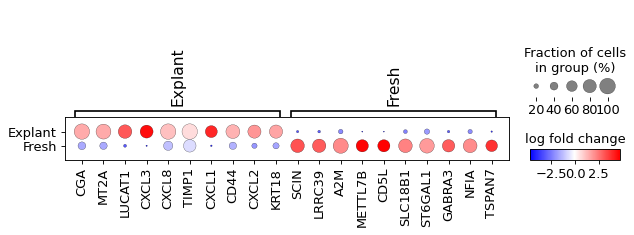

In [144]:
#Plot TF-IDF DE values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=10, dendrogram=False,values_to_plot="logfoldchanges",
                                cmap='bwr', save='rawtfidf_TissueType_HBs_scanpy_10.pdf')

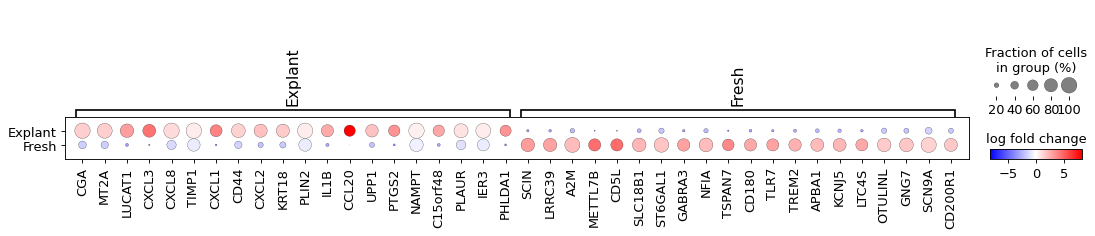

In [145]:
#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=20, dendrogram=False,values_to_plot="logfoldchanges",
                                cmap='bwr',save='rawtfidf_TissueType_HBs_scanpy_20.pdf')

In [150]:
# CHunk to save the DF of DE genes. I am only including genes with a log2fc>0.5
dedf = sc.get.rank_genes_groups_df(adata_bin, group='Explant', log2fc_min=0.5, pval_cutoff=0.001)
dedf.to_csv('../results/tables/DEexplant_vs_fresh/deTFIDF_HB.csv', index=False )

sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2).head(10)

names     scores  logfoldchanges  pvals  pvals_adj
0    LUCAT1  61.976620        3.112538    0.0        0.0
1     CXCL3  60.914593        4.533976    0.0        0.0
2     CXCL1  54.417038        4.047028    0.0        0.0
3      IL1B  52.558659        2.770189    0.0        0.0
4     CCL20  52.187057        8.279038    0.0        0.0
5     PTGS2  50.319839        3.556427    0.0        0.0
6  C15orf48  48.546322        2.859644    0.0        0.0
7    PHLDA1  48.054619        3.515664    0.0        0.0
8       ADM  44.571987        2.478516    0.0        0.0
9     GDF15  43.153343        3.458497    0.0        0.0

#### M3

In [151]:
temp_cells = adata[adata.obs['identity_broad'] == 'M3']
adata_bin= runTF_IDF(temp_cells, groupby='Tissue_type', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


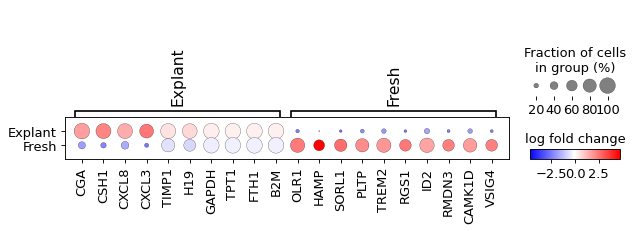

In [152]:
#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=10, dendrogram=False, values_to_plot="logfoldchanges",
                                cmap='bwr', save='rawtfidf_TissueType_M3_scanpy_10.pdf')

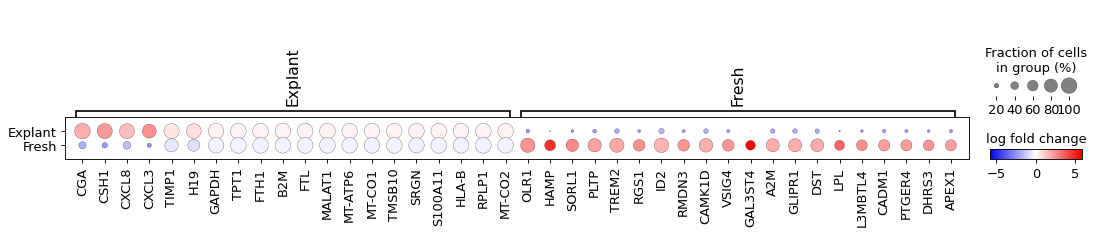

In [153]:
#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=20, dendrogram=False, values_to_plot="logfoldchanges",
                                cmap='bwr', save='rawtfidf_TissueType_M3_scanpy_20.pdf')

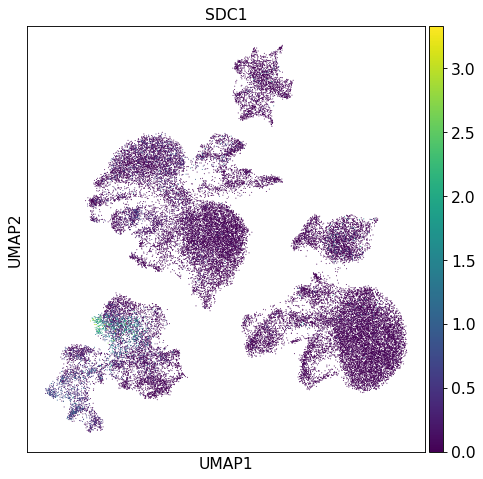

In [154]:

# use scVI imputed values for plotting
sc.pl.umap(adata, color=['SDC1' ],legend_fontsize='xx-small')#, save='_scVI_latent30_labTransfering.pdf')

In [155]:
# CHunk to save the DF of DE genes. I am only including genes with a log2fc>0.5
dedf = sc.get.rank_genes_groups_df(adata_bin, group='Explant', log2fc_min=0.5, pval_cutoff=0.001)
dedf.to_csv('../results/tables/DEexplant_vs_fresh/deTFIDF_M3.csv', index=False )

sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2).head(10)


names     scores  logfoldchanges          pvals      pvals_adj
0     CSH1  35.524975        2.285950  2.023423e-276  3.199538e-272
1    CXCL3  30.795942        2.558951  2.969656e-208  2.347884e-204
2  SLC7A11  27.704561        4.456812  6.152313e-169  5.559054e-166
3    CXCL5  21.914837        5.675452  1.875619e-106  3.802336e-104
4    S100P  18.901958        2.392607   1.098955e-79   1.647131e-77
5     CSH2  16.215616        3.561862   3.911366e-59   4.465594e-57
6    THBS1  15.597017        3.550935   7.627506e-55   8.040663e-53
7    CXCL1  13.233988        3.351775   5.584386e-40   3.830937e-38
8   SLAMF9  12.291909        2.064551   1.001128e-34   5.525425e-33
9     AHRR  10.798123        2.771097   3.513106e-27   1.220901e-25

In [66]:
#list(sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2)[ 'names'])

['CSH1',
 'CXCL3',
 'SLC7A11',
 'CXCL5',
 'S100P',
 'CSH2',
 'THBS1',
 'CXCL1',
 'SLAMF9',
 'AHRR',
 'CD300E',
 'SERPINB2',
 'LINC02154',
 'MET',
 'PSG2',
 'INHBA',
 'FCAR',
 'FSIP1',
 'HSD17B1',
 'AC025048.4',
 'MMP1',
 'PSG3',
 'EPHB1',
 'AC114760.2',
 'DUSP4',
 'PGF',
 'AC009630.1',
 'STC1',
 'CCL20',
 'PPBP',
 'LINC00520',
 'AC009630.4',
 'SLC12A8']

#### EVT

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


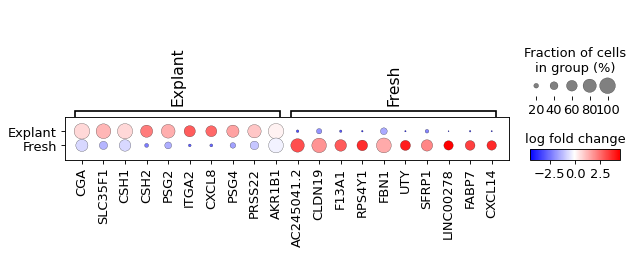

In [156]:
temp_cells = adata[adata.obs['identity_broad'] == 'EVT']
adata_bin= runTF_IDF(temp_cells, groupby='Tissue_type', method='wilcoxon')

#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=10, dendrogram=False, values_to_plot="logfoldchanges",
                                cmap='bwr', save='rawtfidf_TissueType_EVT_scanpy.pdf')

In [160]:
# CHunk to save the DF of DE genes. I am only including genes with a log2fc>0.5
dedf = sc.get.rank_genes_groups_df(adata_bin, group='Explant', log2fc_min=0.5, pval_cutoff=0.001)
dedf.to_csv('../results/tables/DEexplant_vs_fresh/deTFIDF_EVT.csv', index=False )

sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2).head(10)


names     scores  logfoldchanges          pvals      pvals_adj
0    CSH2  22.760235        2.266845  1.136377e-114  5.989653e-111
1   ITGA2  21.887033        2.834648  3.452671e-106  1.364884e-102
2   CXCL8  20.686382        2.636686   4.594218e-95   1.210768e-91
3    PSG6  19.653820        5.039217   5.362132e-86   9.975143e-83
4  GPRC5C  15.388970        2.219416   1.940970e-53   1.557948e-51
5  PHLDA1  14.951172        2.477838   1.530313e-50   1.107463e-48
6   INHBA  12.704247        2.899593   5.600529e-37   2.578118e-35
7   CSHL1  11.792500        3.317742   4.266811e-32   1.651627e-30
8   FOSL1  11.783617        2.619339   4.741379e-32   1.828611e-30
9   CXCL3  10.463194        6.121212   1.274841e-25   3.729587e-24

In [159]:
#list(sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2)[ 'names'])[1:10]

#### SCT

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


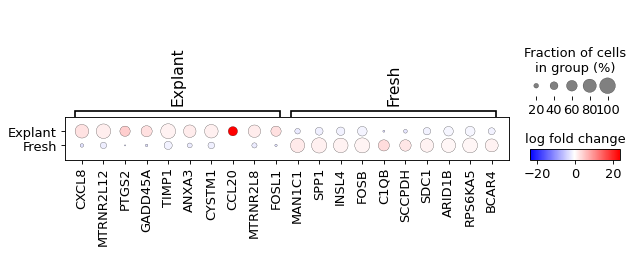

In [161]:
temp_cells = adata[adata.obs['identity_broad'] == 'SCT']
adata_bin= runTF_IDF(temp_cells, groupby='Tissue_type', method='wilcoxon')

#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=10, dendrogram=False, values_to_plot="logfoldchanges",
                                cmap='bwr', save='rawtfidf_TissueType_SCT_scanpy.pdf')

In [163]:
# CHunk to save the DF of DE genes. I am only including genes with a log2fc>0.5
dedf = sc.get.rank_genes_groups_df(adata_bin, group='Explant', log2fc_min=0.5, pval_cutoff=0.001)
dedf.to_csv('../results/tables/DEexplant_vs_fresh/deTFIDF_SCT.csv', index=False )

sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2).head(10)



names     scores  logfoldchanges         pvals     pvals_adj
0     CXCL8  11.776345        2.601671  5.168597e-32  1.634569e-27
1     PTGS2   9.437666        4.527761  3.811765e-21  1.506838e-17
2   GADD45A   9.183081        2.821711  4.189298e-20  1.324866e-16
3     CCL20   8.500519       23.751265  1.887454e-17  3.316152e-14
4     FOSL1   8.353401        2.841515  6.632481e-17  1.048761e-13
5      IL24   8.213984       23.726383  2.139675e-16  3.075782e-13
6   COL14A1   7.740277        2.303111  9.920021e-15  1.018474e-11
7     CXCL2   7.265692       23.636873  3.711330e-13  2.445225e-10
8    LUCAT1   6.950113        2.150607  3.649948e-12  1.956434e-09
9  MARVELD3   6.801915        5.762256  1.032379e-11  4.731736e-09

In [162]:
#list(sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2)[ 'names'])

#### VCT

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


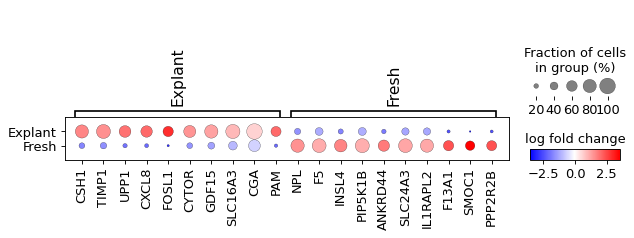

In [164]:
temp_cells = adata[adata.obs['identity_broad'] == 'VCT']
adata_bin= runTF_IDF(temp_cells, groupby='Tissue_type', method='wilcoxon')

#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=10, dendrogram=False, values_to_plot="logfoldchanges",
                                cmap='bwr', save='rawtfidf_TissueType_VCT_scanpy.pdf')

In [165]:
# CHunk to save the DF of DE genes. I am only including genes with a log2fc>0.5
dedf = sc.get.rank_genes_groups_df(adata_bin, group='Explant', log2fc_min=0.5, pval_cutoff=0.001)
dedf.to_csv('../results/tables/DEexplant_vs_fresh/deTFIDF_VCT.csv', index=False )

sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2).head(10)

names     scores  logfoldchanges         pvals     pvals_adj
0   CXCL8  17.860809        2.071833  2.381601e-71  1.075973e-67
1   FOSL1  17.522051        2.897476  9.725408e-69  2.796055e-65
2     PAM  14.958386        2.077195  1.373143e-50  1.447522e-47
3  AGPAT2  13.987418        2.029028  1.860452e-44  1.337200e-41
4    NQO1  13.946717        3.030114  3.294223e-44  2.315107e-41
5  IGFBP5  13.775636        2.285588  3.572229e-43  2.215132e-40
6  LUCAT1  13.545748        3.789916  8.395421e-42  4.916763e-39
7    PSG2  13.182810        3.212675  1.102083e-39  5.532282e-37
8   ITGA2  12.448654        2.819249  1.422234e-35  5.419056e-33
9     SCD  12.234706        2.154904  2.028385e-34  6.972575e-32

In [166]:
#list(sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2)[ 'names'])

#### F1

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:22)


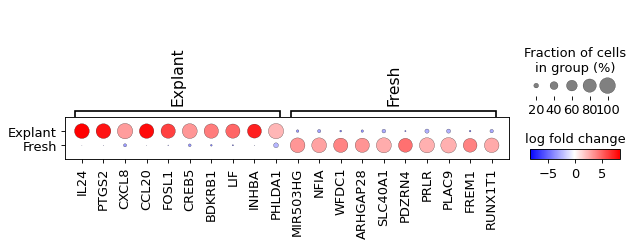

In [167]:
temp_cells = adata[adata.obs['identity_broad'] == 'F1']
adata_bin= runTF_IDF(temp_cells, groupby='Tissue_type', method='wilcoxon')

#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=10, dendrogram=False, values_to_plot="logfoldchanges",
                                cmap='bwr', save='rawtfidf_TissueType_F1_scanpy.pdf')

In [168]:
# CHunk to save the DF of DE genes. I am only including genes with a log2fc>0.5
dedf = sc.get.rank_genes_groups_df(adata_bin, group='Explant', log2fc_min=0.5, pval_cutoff=0.001)
dedf.to_csv('../results/tables/DEexplant_vs_fresh/deTFIDF_F1.csv', index=False )

sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2).head(10)

names     scores  logfoldchanges  pvals  pvals_adj
0    IL24  81.260834        8.253127    0.0        0.0
1   PTGS2  80.887184        7.556963    0.0        0.0
2   CXCL8  79.870331        3.173834    0.0        0.0
3   CCL20  79.213715        7.921703    0.0        0.0
4   FOSL1  77.243958        6.145444    0.0        0.0
5   CREB5  77.100334        3.358550    0.0        0.0
6  BDKRB1  75.773270        4.222601    0.0        0.0
7     LIF  75.728432        4.909781    0.0        0.0
8   INHBA  75.210625        7.175975    0.0        0.0
9  PHLDA1  74.669037        2.321601    0.0        0.0

#### F1_p

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


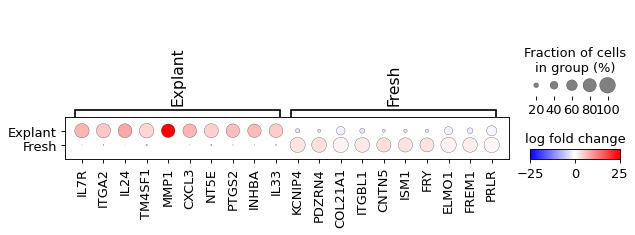

In [169]:
temp_cells = adata[adata.obs['identity_broad'] == 'F1_p']
adata_bin= runTF_IDF(temp_cells, groupby='Tissue_type', method='wilcoxon')

#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=10, dendrogram=False, values_to_plot="logfoldchanges",
                                cmap='bwr', save='rawtfidf_TissueType_F1p_scanpy.pdf')

In [170]:
# CHunk to save the DF of DE genes. I am only including genes with a log2fc>0.5
dedf = sc.get.rank_genes_groups_df(adata_bin, group='Explant', log2fc_min=0.5, pval_cutoff=0.001)
dedf.to_csv('../results/tables/DEexplant_vs_fresh/deTFIDF_F1p.csv', index=False )

sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2).head(10)

names     scores  logfoldchanges          pvals      pvals_adj
0    IL7R  25.346933        7.386285  9.714162e-142  1.536052e-137
1   ITGA2  24.587927        5.462752  1.700755e-133  1.344659e-129
2    IL24  24.352308        8.878337  5.479853e-131  2.888339e-127
3  TM4SF1  24.217606        4.335592  1.451672e-129  6.558447e-126
4    MMP1  23.739668       25.286877  1.404864e-124  4.442882e-121
5   CXCL3  23.627552        7.445608  2.008471e-123  5.774354e-120
6    NT5E  23.585405        4.670705  5.441673e-123  1.434107e-119
7   PTGS2  23.418564        6.398653  2.765181e-121  6.246346e-118
8   INHBA  23.100031        6.872267  4.626734e-118  9.754698e-115
9    IL33  22.963030        4.940803  1.091896e-116  2.158201e-113

#### F2

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


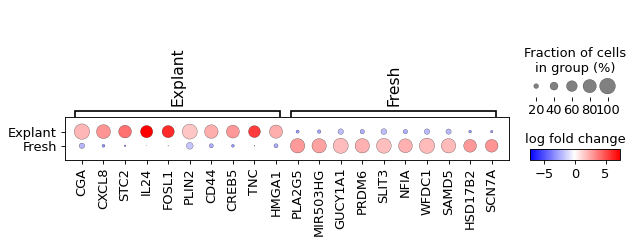

In [171]:
temp_cells = adata[adata.obs['identity_broad'] == 'F2']
adata_bin= runTF_IDF(temp_cells, groupby='Tissue_type', method='wilcoxon')

#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=10, dendrogram=False, values_to_plot="logfoldchanges",
                                cmap='bwr', save='rawtfidf_TissueType_F2_scanpy.pdf')

In [172]:
# CHunk to save the DF of DE genes. I am only including genes with a log2fc>0.5
dedf = sc.get.rank_genes_groups_df(adata_bin, group='Explant', log2fc_min=0.5, pval_cutoff=0.001)
dedf.to_csv('../results/tables/DEexplant_vs_fresh/deTFIDF_F2.csv', index=False )

sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2).head(10)

names     scores  logfoldchanges          pvals      pvals_adj
0    CGA  28.142269        2.107826  2.979676e-174  9.423225e-170
1  CXCL8  26.748569        3.045012  1.283026e-157  2.028785e-153
2   STC2  25.261778        4.080349  8.407652e-141  5.317840e-137
3   IL24  25.056513        7.351918  1.482604e-138  7.814560e-135
4  FOSL1  24.714628        6.132536  7.446676e-135  2.943764e-131
5   CD44  23.972513        2.344313  5.382609e-127  1.309423e-123
6  CREB5  23.940613        2.970507  1.157360e-126  2.614394e-123
7    TNC  23.769812        5.582486  6.856354e-125  1.275484e-121
8  HMGA1  23.519308        2.350291  2.588409e-122  4.308339e-119
9  RUNX1  22.631363        2.008824  2.129190e-113  2.927636e-110